In [1]:
import pandas as pd
import numpy as np
import sys
import os
import scipy.stats as stats
import time
import tqdm
import seaborn as sns
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load CSV

In [2]:
train_txt_path = '../dataset/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

df_train = pd.read_csv(train_txt_path, sep=" ", header=None)
df_train.columns = ["speaker_id", "audio_filename", "null", "system_id", "label"]
df_train = df_train.drop(columns="null")

dev_txt_path = '../dataset/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'

df_dev = pd.read_csv(dev_txt_path, sep=" ", header=None)
df_dev.columns = ["speaker_id", "audio_filename", "null", "system_id", "label"]
df_dev = df_dev.drop(columns="null")

eval_txt_path = '../dataset/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'

df_eval = pd.read_csv(eval_txt_path, sep=" ", header=None)
df_eval.columns = ["speaker_id", "audio_filename", "null", "system_id", "label"]
df_eval = df_eval.drop(columns="null")

### Params

In [3]:
nfft = 64
hop_size = 32 

### Train features

In [4]:
train_feat_root_path = '../features/bicoherences/train_nfft_{}_hop_size_{}'.format(nfft, hop_size)

df_train["mean_mag"] = np.nan
df_train["var_mag"] = np.nan
df_train["skew_mag"] = np.nan
df_train["kurt_mag"] = np.nan

df_train["mean_phase"] = np.nan
df_train["var_phase"] = np.nan
df_train["skew_phase"] = np.nan
df_train["kurt_phase"] = np.nan


for index, row in tqdm.tqdm(df_train.iterrows(), total=df_train.shape[0]):
    feat_path = os.path.join(train_feat_root_path, row['audio_filename'] + '.npy')
    bicoh = np.load(feat_path)
    mag = np.abs(bicoh)
    phase = np.angle(bicoh)
    df_train.at[index, 'mean_mag'] = np.mean(mag)
    df_train.at[index, 'var_mag'] = np.var(mag)
    df_train.at[index, 'skew_mag'] = stats.skew(mag, axis=None)
    df_train.at[index, 'kurt_mag'] = stats.kurtosis(mag, axis=None)
    
    df_train.at[index, 'mean_phase'] = np.mean(phase)
    df_train.at[index, 'var_phase'] = np.var(phase)
    df_train.at[index, 'skew_phase'] = stats.skew(phase, axis=None)
    df_train.at[index, 'kurt_phase'] = stats.kurtosis(phase, axis=None)



100%|██████████| 25380/25380 [01:21<00:00, 310.30it/s]


In [5]:
# sns.pairplot(data=df_train.iloc[:,3:11], hue='label')

### Load dev features

In [6]:
dev_feat_root_path = '../features/bicoherences/dev_nfft_{}_hop_size_{}'.format(nfft, hop_size)

df_dev["mean_mag"] = np.nan
df_dev["var_mag"] = np.nan
df_dev["skew_mag"] = np.nan
df_dev["kurt_mag"] = np.nan

df_dev["mean_phase"] = np.nan
df_dev["var_phase"] = np.nan
df_dev["skew_phase"] = np.nan
df_dev["kurt_phase"] = np.nan


for index, row in tqdm.tqdm(df_dev.iterrows(), total=df_dev.shape[0]):
    feat_path = os.path.join(dev_feat_root_path, row['audio_filename'] + '.npy')
    bicoh = np.load(feat_path)
    mag = np.abs(bicoh)
    phase = np.angle(bicoh)
    df_dev.at[index, 'mean_mag'] = np.mean(mag)
    df_dev.at[index, 'var_mag'] = np.var(mag)
    df_dev.at[index, 'skew_mag'] = stats.skew(mag, axis=None)
    df_dev.at[index, 'kurt_mag'] = stats.kurtosis(mag, axis=None)
    
    df_dev.at[index, 'mean_phase'] = np.mean(phase)
    df_dev.at[index, 'var_phase'] = np.var(phase)
    df_dev.at[index, 'skew_phase'] = stats.skew(phase, axis=None)
    df_dev.at[index, 'kurt_phase'] = stats.kurtosis(phase, axis=None)



100%|██████████| 24844/24844 [01:21<00:00, 304.89it/s]


### Prepare data

In [7]:
X_train = df_train.iloc[:, 4:].values
y_train = df_train.iloc[:, 3].values
y_train = [1 if i=='spoof' else 0 for i in y_train]

In [8]:
X_test = df_dev.iloc[:, 4:].values
y_test = df_dev.iloc[:, 3].values
y_test = [1 if i=='spoof' else 0 for i in y_test]

### Binary SVM

In [9]:
clf = svm.SVC(class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

 NFFT = 256, HOP_SIZE = 128
 
 0.89

In [10]:
clf.score(X_test, y_test)

0.5888745773627435

In [11]:
y_predict = clf.predict(X_test)
confusion_matrix(y_test, y_predict)

array([[ 1805,   743],
       [ 9471, 12825]])

### Multiclass SVM

In [12]:
multiclass_dict = {'-':0, 'A01':1, 'A02':2, 'A03':3, 'A04':4, 'A05':5, 'A06':6}
y_train_multiclass = df_train.iloc[:, 2].values
y_train_multiclass = [multiclass_dict[a] for a in y_train_multiclass]

y_test_multiclass = df_dev.iloc[:, 2].values
y_test_multiclass = [multiclass_dict[a] for a in y_test_multiclass]

In [13]:
mclf = svm.SVC()
mclf.fit(X_train, y_train_multiclass)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

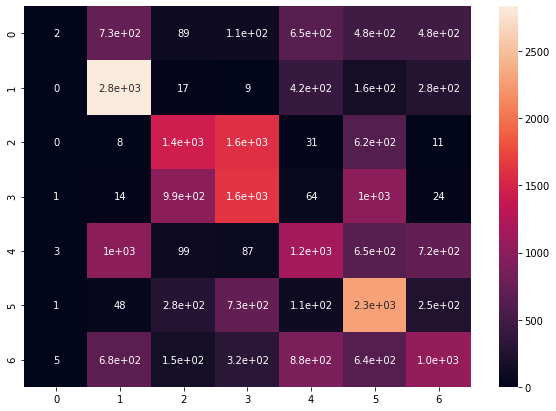

In [16]:
y_predict_multiclass = mclf.predict(X_test)
cm = confusion_matrix(y_test_multiclass, y_predict_multiclass)


plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)